In [9]:
from math import pi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython
from scipy.io.wavfile import write, read
import numpy as np; import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

In [2]:
np.seterr(invalid="ignore")

length = 32768
xn = (np.random.rand(length) - 0.5) * 2 + np.sin(2048 * np.linspace(0, 2 * np.pi, length))
yn = (np.random.rand(length) - 0.5) * 2 + np.sin(2048 * np.linspace(0, 2 * np.pi, length))

frameSize = 64
fftSize = 256
iteration = (length // frameSize) - (fftSize // frameSize) + 1

phi11 = 0 
phi22 = 0 
phi12 = 0

# forgetting factor
lambda_ = 0.05
coherence = np.zeros([iteration, fftSize//2 + 1])

window = signal.get_window("hann", fftSize//2 + 1)

for index in range(iteration):
    start = index * frameSize
    end = start + fftSize
    xn_ = xn[start:end]
    yn_ = yn[start:end]
    
    Xn = np.fft.rfft(xn_) * window
    Yn = np.fft.rfft(yn_) * window

    phi11 = ((1 - lambda_) * phi11 + lambda_ * Xn * np.conjugate(Xn)).real
    phi22 = ((1 - lambda_) * phi22 + lambda_ * Yn * np.conjugate(Yn)).real
    phi12 = ((1 - lambda_) * phi12 + lambda_ * Xn * np.conjugate(Yn))

    coherence[index] = np.abs(phi12) ** 2 / (phi11 * phi22)

In [3]:
coherence = np.nan_to_num(coherence, 0)

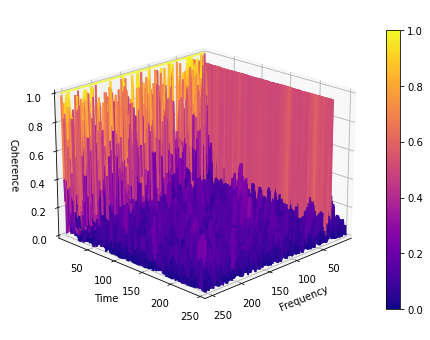

In [15]:
def waterfall_plot(fig,ax,X,Y,Z):
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())

    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)        
        lc = LineCollection(segments, cmap='plasma', norm=norm)
        # Set the values used for colormapping
        lc.set_array((Z[j,1:]+Z[j,:-1])/2)
        lc.set_linewidth(2) # set linewidth a little larger to see properly the colormap variation
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    fig.colorbar(lc, fraction=0.025, pad=0.04)

# Prepare data
x = np.linspace(1, fftSize//2 + 1, fftSize//2 + 1)
y = np.linspace(1, iteration, iteration)
X,Y = np.meshgrid(x,y)
Z = coherence

# Generate waterfall plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
waterfall_plot(fig,ax,X,Y,Z) 

# Axes scaling
ax.set_xlabel('Frequency')
ax.set_xlim3d(1,fftSize//2 + 1)
ax.set_ylabel('Time')
ax.set_ylim3d(1,iteration)
ax.set_zlabel('Coherence')
ax.set_zlim3d(0,1)

# Rotate
elevation = 20
angle = 45
ax.view_init(elev = elevation, azim=angle)

plt.show()